In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import hashlib
import json
import pickle
import gzip
import re
import os

import nltk
from nltk.probability import FreqDist
from nltk.tokenize import TweetTokenizer, word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from wordcloud import WordCloud

import spacy

from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.decomposition import PCA, TruncatedSVD

In [2]:
# connect to Google Drive instance. 
#Note: this must be rerun each time a new Colab session is established!
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
drive_path = "/content/gdrive/My Drive/Data Science/Capstone/"

In [4]:
os.chdir(drive_path)

In [5]:
from ml_tools import model_eval, nlp_prep, eda

In [6]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# OBTAIN

### Stopwords

In [10]:
# starting with nltk's stopwords list
nltk.download('stopwords')
nltk_stopwords = stopwords.words('english')
nltk_stopwords.sort()
print(nltk_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'isn', "isn't", 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 'r

In [11]:
import string
punc = list(string.punctuation)
print(punc)

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']


In [12]:
you_list = ['you', "you'd", "you'll", "you're", "you've", 'your', 'yours',
            'yourself', 'yourselves']
custom_stopwords = [word for word in nltk_stopwords if word not in you_list]

custom_punc = punc.copy()
custom_punc.remove('?')

# Model Facebook Posts Only

## Preprocessing

In [13]:
f = gzip.open('data/cleaned_data.pickle.gz','rb')
df = pickle.load(f)
f.close()

In [14]:
df.head()

,id,name,message,description,caption,post_type,status_type,comments_count,shares_count,link,posted_at,print_section,print_page,snippet,lead_paragraph,main_headline,news_desk,section_name,type_of_material,word_count,glocations,subject,persons,organizations,creative_works,is_matched,all_text,likes_loves,shares_outliers,comments_outliers,likelove_outliers,comments_pct,shares_pct,likesloves_pct,max_pct,mean_pct,all_binary,all_multi,comments_pct_m,shares_pct_m,likesloves_pct_m,max_pct_m,mean_pct_m,m_binary,m_multi,is_interactive,is_video,is_slideshow,word_count_cat,has_person,has_org,has_geo,is_multimedia,day_name,month,hour,year,hour_cat,on_weekend,text_hash,cleaned,article_text
0,5281959998_416259568436280,Did Barack Obama Save Ohio?,"'There are several pivotal states — Ohio, Flor...",Why the battle to take credit for Ohio’s ever-...,nytimes.com,link,shared_story,44,68,http://www.nytimes.com/2012/09/09/magazine/ohi...,2012-09-08 15:16:55,MM,28,Why the battle to take credit for Ohio’s ever-...,"The way John Kasich sees it, he is fulfilling ...",Did Barack Obama Save Ohio?,Magazine,Magazine,News,7113.0,"[ohio, columbus (ohio), lorain (ohio), cincinn...","[automobiles, economic conditions and trends, ...","[kasich, john r, portman, rob, geithner, timot...",[jobsohio],NaN,1.0,Did Barack Obama Save Ohio?. 'There are severa...,413,NaN,NaN,NaN,0.334089,0.291167,0.316133,0.334089,0.313796,0.0,1.0,0.331610,0.285285,0.320887,0.331610,0.312594,0.0,1.0,0.0,0.0,0.0,High,1,1,1,0.0,Saturday,September,11,2012,3_Midday (11-15),1.0,096d07323e2038648476a541de2ada8d,Did Barack Obama Save Ohio?. 'There are severa...,Did Barack Obama Save Ohio?. Why the battle to...
1,5281959998_268320586619940,The Weatherman Is Not a Moron,"In 1940, the chance of an American being kille...",In the hocus-pocus realm of predicting the fut...,nytimes.com,link,shared_story,14,78,http://www.nytimes.com/2012/09/09/magazine/the...,2012-09-08 16:01:13,MM,34,In the hocus-pocus realm of predicting the fut...,"From the inside, the National Centers for Envi...",The Weatherman Is Not a Moron,Magazine,Magazine,News,3915.0,NaN,"[weather, books and literature, hurricanes and...","[richardson, lewis fry, lorenz, edward norton]","[national center for atmospheric research, int...",NaN,1.0,"The Weatherman Is Not a Moron. In 1940, the ch...",338,NaN,NaN,NaN,0.076672,0.327404,0.250366,0.327404,0.218147,0.0,0.0,0.075161,0.322426,0.253568,0.322426,0.217052,0.0,0.0,0.0,0.0,0.0,High,1,1,0,0.0,Saturday,September,12,2012,3_Midday (11-15),1.0,5e86df62b92f49a745ceec6f60fff61c,"The Weatherman Is Not a Moron. In , the chance...",The Weatherman Is Not a Moron. In the hocus-po...
2,5281959998_467433813289503,The Organic Fable,"'Organic has long since become an ideology, th...",A study exposes the hype behind a pseudoscient...,nytimes.com,link,shared_story,290,421,http://www.nytimes.com/2012/09/07/opinion/roge...,2012-09-08 16:44:02,None,None,A study exposes the hype behind a pseudoscient...,LONDON — At some point — perhaps it was gazing...,The Organic Fable,Editorial,Opinion,Op-Ed,866.0,[great britain],"[food, organic foods and products, medicine an...",NaN,NaN,NaN,1.0,The Organic Fable. 'Organic has long since bec...,812,NaN,NaN,NaN,0.858710,0.759057,0.550338,0.858710,0.722702,0.0,1.0,0.862470,0.760786,0.558817,0.862470,0.727358,0.0,1.0,0.0,0.0,0.0,Average,0,0,1,0.0,Saturday,September,12,2012,3_Midday (11-15),1.0,f57f419a288a8182668277d83b95637f,The Organic Fable. 'Organic has long since bec...,The Organic Fable. A study exposes the hype be...
3,5281959998_10150252974589999,Timeline Photos,Our special Arts & Leisure section 'The New Se...,NaN,None,photo,added_photos,17,99,https://www.facebook.com/nytimes/photos/a.2835...,2012-09-08 17:32:18,Not matched,Not matched,NaN,NaN,NaN,Not matched,Not matched,Not matched,0.0,NaN,[No Subject],NaN,NaN,NaN,0.0,Timeline Photos. Our special Arts & Leisure se...,513,NaN,NaN,NaN,0.103852,0.392418,0.390423,0.392418,0.295565,0.0,1.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0

In [15]:
# constants for column names involved
text_col = 'cleaned'
cat_cols = ['post_type', 'hour_cat', 'on_weekend']

In [16]:
# initial X and y set for all posts
X = df[[text_col] + cat_cols]
y = df['all_binary']

In [17]:
# 0 is average, 1 is high engagement
class_labels = ['Low', 'High']

# 0 is average, 1 is moderate, 2 is high
mclass_labels = ['Low', 'Moderate', 'High']

In [18]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                               stratify=y)
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

38292
38292
9574
9574


In [19]:
# Create multi-class y_train using the same indices as binary
y_train_multi = df[df.index.isin(y_train.index)]['all_multi']
y_train_multi = y_train_multi.reindex(index=list(y_train.index))

# Create multi-class y_test using the same indices as binary
y_test_multi = df[df.index.isin(y_test.index)]['all_multi']
y_test_multi = y_test_multi.reindex(index=list(y_test.index))

## Build ColumnTransformer

In [20]:
# text pre-processing pipeline to transform full sentences into vectors
tweettokenizer = TweetTokenizer(preserve_case=False, strip_handles=True)

txt_trans_pipe = Pipeline([
    ('vect', CountVectorizer(tokenizer=tweettokenizer.tokenize)),
    ('tfidf', TfidfTransformer())
])

def no_analyzer(doc):
    """Pass-through function to avoid transforming tokens lists.
    """
    return doc

# creating a column transformer to combine OHE of cat cols, basic count
# vectorization of subject, and tokenizing and vectorization of cleaned text
cols_trans = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first'), cat_cols),
    #('txt_kw', CountVectorizer(analyzer=no_analyzer), 'subject'),
    ('txt', txt_trans_pipe, 'cleaned')
])

# Params that will apply to the vectorizer regardless of how the
# document term matrix is constructed
common_params = {"cols_trans__txt__vect__stop_words": [custom_stopwords + custom_punc,
                                                       nltk_stopwords + punc],
    "cols_trans__txt__vect__ngram_range": [(1, 1), (1,2)],
    "cols_trans__txt__vect__max_features": [None, 10000, 100000]}

# Params for the binary frequency, where we don't want to bother with a Tfidf
binary_params = {
    "cols_trans__txt__vect__binary": [True],
    "cols_trans__txt__tfidf": ['passthrough']}

# params for non-binary frequency, where we want to test both with and without
# Tfidf
count_params = {
    "cols_trans__txt__vect__binary": [False],
    "cols_trans__txt__tfidf": [TfidfTransformer(), 'passthrough']}

In [21]:
# Path I'm going to use to save best estimators from gridsearching
save_path = "models/"

## Gridsearch LR - no lemmas

This is primarily gridsearching different text vectorizers.

In [22]:
clf_pipe = Pipeline([
    ('cols_trans', cols_trans),
    ('clf', LogisticRegression(max_iter=300, 
                            class_weight='balanced',
                            penalty='l2',
                            fit_intercept=False,
                            solver='saga',
                            C=0.1))
])


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 39.4min finished


Pipeline(memory=None,
         steps=[('cols_trans',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('ohe',
                                                  OneHotEncoder(categories='auto',
                                                                drop='first',
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True),
                                                  ['post_type', 'hour_cat',
                                                   'on_weekend']),
                                                 ('txt',
                                                  Pipeline(memory=None,
            

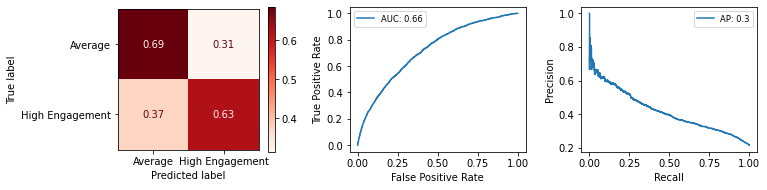

In [ ]:

grid_params = [{**common_params, **binary_params},
               {**common_params, **count_params}]

model_name = "LR_all_binary"

# run gridsearch for LR
model_eval.clf_gridsearch_wpipe(clf_pipe, grid_params, X_train, y_train, X_test, 
        y_test, class_labels, file_name=model_name, save_path=save_path, 
        scoring='recall', score_type='std', verbose=1)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 44.3min finished


Pipeline(memory=None,
         steps=[('cols_trans',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('ohe',
                                                  OneHotEncoder(categories='auto',
                                                                drop='first',
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True),
                                                  ['post_type', 'hour_cat',
                                                   'on_weekend']),
                                                 ('txt',
                                                  Pipeline(memory=None,
            

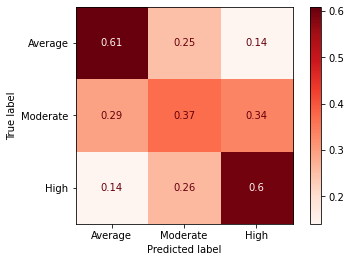

In [ ]:
model_name = "LR_all_multi"

# run gridsearch for LR
model_eval.clf_gridsearch_wpipe(clf_pipe, grid_params, X_train, y_train_multi,  
        X_test, y_test_multi, mclass_labels, file_name=model_name,  
        save_path=save_path, scoring='recall_macro', score_type='std', verbose=1)

## Gridsearch LR - with lemmas

In [ ]:
# GS for LR binary with lemmatizing
txt_trans_pipe = Pipeline([
    ('vect', CountVectorizer(tokenizer=nlp_prep.tokenize_lemma)),
    ('tfidf', TfidfTransformer())
])

# creating a column transformer to combine OHE of cat cols, basic count
# vectorization of subject, and tokenizing and vectorization of cleaned text
cols_trans = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first'), cat_cols),
    #('txt_kw', CountVectorizer(analyzer=no_analyzer), 'subject'),
    ('txt', txt_trans_pipe, 'cleaned')
])

clf_pipe = Pipeline([
    ('cols_trans', cols_trans),
    ('clf', LogisticRegression(max_iter=300, 
                            class_weight='balanced',
                            penalty='l2',
                            fit_intercept=False,
                            solver='saga',
                            C=0.1))
])

grid_params = [{**common_params, **binary_params},
               {**common_params, **count_params}]

model_name = "LR_all_binary_lem"

# run gridsearch for LR
model_eval.clf_gridsearch_wpipe(clf_pipe, grid_params, X_train, y_train, X_test, 
        y_test, class_labels, file_name=model_name, save_path=save_path, 
        scoring='recall', score_type='std', verbose=1, n_jobs=1)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent wi

KeyboardInterrupt: ignored

In [ ]:
# with lemmatization
model_name = "LR_all_multi_lem"

# run gridsearch for LR
model_eval.clf_gridsearch_wpipe(clf_pipe, grid_params, X_train, y_train_multi,  
        X_test, y_test_multi, mclass_labels, file_name=model_name,  
        save_path=save_path, scoring='recall_macro', score_type='std', verbose=1,
        n_jobs=1)

## Gridsearch LR - different feature counts


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  5.0min finished


Pipeline(memory=None,
         steps=[('cols_trans',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('ohe',
                                                  OneHotEncoder(categories='auto',
                                                                drop='first',
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True),
                                                  ['post_type', 'hour_cat',
                                                   'on_weekend']),
                                                 ('txt',
                                                  Pipeline(memory=None,
            

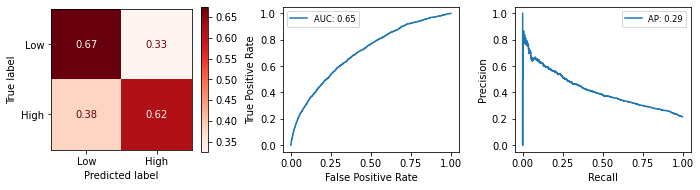

In [31]:
grid_params = {"cols_trans__txt__vect__max_features": [1000, 2000, 5000, 10000, 20000],
               "cols_trans__txt__vect__stop_words": [custom_stopwords + custom_punc],
               "cols_trans__txt__vect__ngram_range": [(1,2)]}

model_name = "LR_all_binary_feats"

# run gridsearch for LR
model_eval.clf_gridsearch_wpipe(clf_pipe, grid_params, X_train, y_train, X_test, 
        y_test, class_labels, file_name=model_name, save_path=save_path, 
        scoring='recall', score_type='std', verbose=1)

In [32]:
f = gzip.open('models/GSObject_LR_all_binary_feats.joblib.gz','rb')
best_pipe = joblib.load(f)
f.close()

best_pipe.best_estimator_.get_params()

{'clf': LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                    fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                    max_iter=300, multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='saga', tol=0.0001, verbose=0,
                    warm_start=False),
 'clf__C': 0.1,
 'clf__class_weight': 'balanced',
 'clf__dual': False,
 'clf__fit_intercept': False,
 'clf__intercept_scaling': 1,
 'clf__l1_ratio': None,
 'clf__max_iter': 300,
 'clf__multi_class': 'auto',
 'clf__n_jobs': None,
 'clf__penalty': 'l2',
 'clf__random_state': None,
 'clf__solver': 'saga',
 'clf__tol': 0.0001,
 'clf__verbose': 0,
 'clf__warm_start': False,
 'cols_trans': ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                   transformer_weights=None,
                   transformers=[('ohe',
                                  OneHotEncoder(categories='auto', drop='first',
                              

## Gridsearch LR - Multi - different feature counts

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  5.4min finished


Pipeline(memory=None,
         steps=[('cols_trans',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('ohe',
                                                  OneHotEncoder(categories='auto',
                                                                drop='first',
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True),
                                                  ['post_type', 'hour_cat',
                                                   'on_weekend']),
                                                 ('txt',
                                                  Pipeline(memory=None,
            

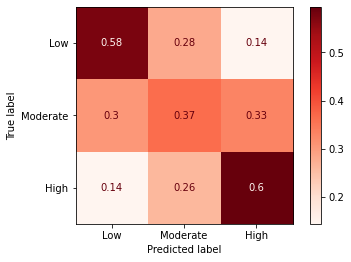

In [23]:
grid_params = {"cols_trans__txt__vect__max_features": [1000, 2000, 5000, 10000, 20000],
               "cols_trans__txt__vect__stop_words": [custom_stopwords + custom_punc],
               "cols_trans__txt__vect__ngram_range": [(1,2)]}

model_name = "LR_all_multi_feats"

# run gridsearch for LR
model_eval.clf_gridsearch_wpipe(clf_pipe, grid_params, X_train,
        y_train_multi, X_test, y_test_multi, mclass_labels, 
        file_name=model_name, save_path=save_path, scoring='recall_macro', 
        score_type='std', verbose=1)

In [24]:
f = gzip.open('models/GSObject_LR_all_multi_feats.joblib.gz','rb')
best_pipe = joblib.load(f)
f.close()

best_pipe.best_estimator_.get_params()

{'clf': LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                    fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                    max_iter=300, multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='saga', tol=0.0001, verbose=0,
                    warm_start=False),
 'clf__C': 0.1,
 'clf__class_weight': 'balanced',
 'clf__dual': False,
 'clf__fit_intercept': False,
 'clf__intercept_scaling': 1,
 'clf__l1_ratio': None,
 'clf__max_iter': 300,
 'clf__multi_class': 'auto',
 'clf__n_jobs': None,
 'clf__penalty': 'l2',
 'clf__random_state': None,
 'clf__solver': 'saga',
 'clf__tol': 0.0001,
 'clf__verbose': 0,
 'clf__warm_start': False,
 'cols_trans': ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                   transformer_weights=None,
                   transformers=[('ohe',
                                  OneHotEncoder(categories='auto', drop='first',
                              

Gridsearch for the binary classifier did better with only 2000 max features. But for multi-class, 10k was better than other options.

## Gridsearch MNB - no lemmas

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 32.0min finished


Pipeline(memory=None,
         steps=[('cols_trans',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('ohe',
                                                  OneHotEncoder(categories='auto',
                                                                drop='first',
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True),
                                                  ['post_type', 'hour_cat',
                                                   'on_weekend']),
                                                 ('txt',
                                                  Pipeline(memory=None,
            

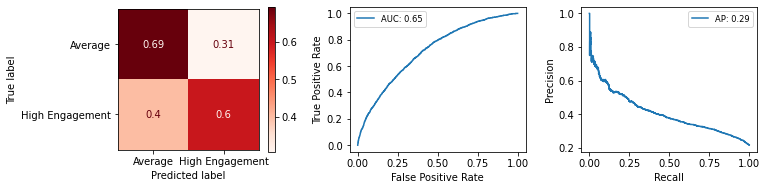

In [ ]:
# GS for LR binary with lemmatizing
txt_trans_pipe = Pipeline([
    ('vect', CountVectorizer(tokenizer=tweettokenizer.tokenize)),
    ('tfidf', TfidfTransformer())
])

# creating a column transformer to combine OHE of cat cols, basic count
# vectorization of subject, and tokenizing and vectorization of cleaned text
cols_trans = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first'), cat_cols),
    #('txt_kw', CountVectorizer(analyzer=no_analyzer), 'subject'),
    ('txt', txt_trans_pipe, 'cleaned')
])

clf_pipe = Pipeline([
    ('cols_trans', cols_trans),
    ('clf', MultinomialNB(fit_prior=False, alpha=0.5))
])

grid_params = [{**common_params, **binary_params},
               {**common_params, **count_params}]

model_name = "MNB_all_binary"

# run gridsearch for MNB
model_eval.clf_gridsearch_wpipe(clf_pipe, grid_params, X_train, y_train, X_test, 
        y_test, class_labels, file_name=model_name, save_path=save_path, 
        scoring='recall', score_type='std', verbose=1, n_jobs=-1)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 31.8min finished


Pipeline(memory=None,
         steps=[('cols_trans',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('ohe',
                                                  OneHotEncoder(categories='auto',
                                                                drop='first',
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True),
                                                  ['post_type', 'hour_cat',
                                                   'on_weekend']),
                                                 ('txt',
                                                  Pipeline(memory=None,
            

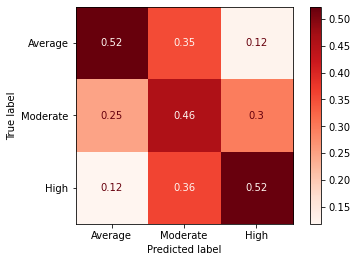

In [ ]:
model_name = "MNB_all_multi"

# run gridsearch for MNB
model_eval.clf_gridsearch_wpipe(clf_pipe, grid_params, X_train, y_train_multi,  
        X_test, y_test_multi, mclass_labels, file_name=model_name,  
        save_path=save_path, scoring='recall_macro', score_type='std', verbose=1,
        n_jobs=-1)

# Model Matched Articles

## Preprocessing

In [23]:
f = gzip.open('data/cleaned_article_data.pickle.gz','rb')
df_articles = pickle.load(f)
f.close()

In [24]:
cat_cols = ['section_name', 'word_count_cat', 'is_multimedia', 'has_person', 
            'has_org', 'has_geo']

Xmat = df_articles[['cleaned', 'subject'] + cat_cols]
ymat = df_articles['m_binary']

In [25]:
# train test split
X_train_mat, X_test_mat, y_train_mat, y_test_mat = train_test_split(Xmat, ymat, 
                                    test_size=0.2, stratify=ymat)
print(len(X_train_mat))
print(len(y_train_mat))
print(len(X_test_mat))
print(len(y_test_mat))

34581
34581
8646
8646


In [26]:
# Create multi-class y_train using the same indices as binary
y_train_mat_multi = df_articles[df_articles.index.isin(y_train_mat.index)]['m_multi']
y_train_mat_multi = y_train_mat_multi.reindex(index=list(y_train_mat.index))

# Create multi-class y_test using the same indices as binary
y_test_mat_multi = df_articles[df_articles.index.isin(y_test_mat.index)]['m_multi']
y_test_mat_multi = y_test_mat_multi.reindex(index=list(y_test_mat.index))

In [27]:
print(y_train_mat.value_counts())
print(y_train_mat_multi.value_counts())

0.0    27140
1.0     7441
Name: m_binary, dtype: int64
1.0    19716
2.0     7441
0.0     7424
Name: m_multi, dtype: int64


In [30]:
# No lemmatization
tweettokenizer = TweetTokenizer(preserve_case=False, strip_handles=True)

txt_trans_pipe2 = Pipeline([
    ('vect', CountVectorizer(tokenizer=tweettokenizer.tokenize,
                            stop_words=custom_stopwords + custom_punc,
                            ngram_range=(1, 2),
                            max_features=10000)),
    ('tfidf', TfidfTransformer())
])

# creating a column transformer to combine OHE of cat cols, basic count
# vectorization of subject, and tokenizing and vectorization of cleaned text
m_cols_trans2 = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first'), cat_cols),
    ('txt_kw', CountVectorizer(analyzer=no_analyzer), 'subject'),
    ('txt', txt_trans_pipe2, 'cleaned')
])

## Gridsearch LR - binary - No lemmas - feature counts

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  6.5min finished


Pipeline(memory=None,
         steps=[('cols_trans',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('ohe',
                                                  OneHotEncoder(categories='auto',
                                                                drop='first',
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True),
                                                  ['section_name',
                                                   'word_count_cat',
                                                   'is_multimedia',
                                                   'has_person', 'has_org',
    

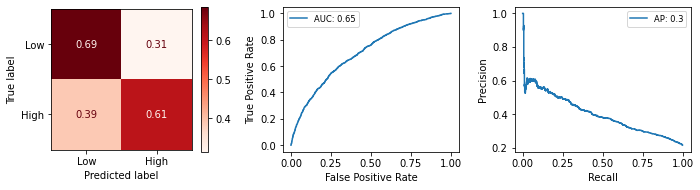

In [33]:
clf_pipe_m = Pipeline([
    ('cols_trans', m_cols_trans2),
    ('clf', LogisticRegression(max_iter=300, 
                            class_weight='balanced',
                            penalty='l2',
                            fit_intercept=False,
                            solver='saga',
                            C=0.1))
])

grid_params = {"cols_trans__txt__vect__max_features": [1000, 2000, 5000, 10000, 20000],
               "cols_trans__txt__vect__stop_words": [custom_stopwords + custom_punc],
               "cols_trans__txt__vect__ngram_range": [(1,2)]}

model_name = "LR_mat_binary_feats"

# run gridsearch for LR
model_eval.clf_gridsearch_wpipe(clf_pipe_m, grid_params, X_train_mat, y_train_mat, 
                                X_test_mat, y_test_mat, class_labels, 
                                file_name=model_name, save_path=save_path, 
                                scoring='recall', score_type='std', verbose=1)

In [31]:
f = gzip.open('models/GSObject_LR_mat_binary_feats.joblib.gz','rb')
best_pipe = joblib.load(f)
f.close()

best_pipe.best_estimator_.get_params()

{'clf': LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                    fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                    max_iter=300, multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='saga', tol=0.0001, verbose=0,
                    warm_start=False),
 'clf__C': 0.1,
 'clf__class_weight': 'balanced',
 'clf__dual': False,
 'clf__fit_intercept': False,
 'clf__intercept_scaling': 1,
 'clf__l1_ratio': None,
 'clf__max_iter': 300,
 'clf__multi_class': 'auto',
 'clf__n_jobs': None,
 'clf__penalty': 'l2',
 'clf__random_state': None,
 'clf__solver': 'saga',
 'clf__tol': 0.0001,
 'clf__verbose': 0,
 'clf__warm_start': False,
 'cols_trans': ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                   transformer_weights=None,
                   transformers=[('ohe',
                                  OneHotEncoder(categories='auto', drop='first',
                              

## Gridsearch LR - multi - No lemmas - feature counts

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  6.5min finished


Pipeline(memory=None,
         steps=[('cols_trans',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('ohe',
                                                  OneHotEncoder(categories='auto',
                                                                drop='first',
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True),
                                                  ['section_name',
                                                   'word_count_cat',
                                                   'is_multimedia',
                                                   'has_person', 'has_org',
    

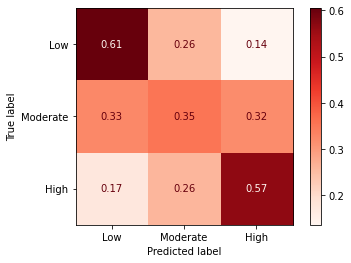

In [34]:
model_name = "LR_mat_multi_feats"

# run gridsearch for LR
model_eval.clf_gridsearch_wpipe(clf_pipe_m, grid_params, X_train_mat,
                                 y_train_mat_multi, X_test_mat, y_test_mat_multi, 
                                mclass_labels, file_name=model_name, 
                                save_path=save_path, scoring='recall_macro', 
                                score_type='std', verbose=1)

In [32]:
f = gzip.open('models/GSObject_LR_mat_multi_feats.joblib.gz','rb')
best_pipe = joblib.load(f)
f.close()

best_pipe.best_estimator_.get_params()

{'clf': LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                    fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                    max_iter=300, multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='saga', tol=0.0001, verbose=0,
                    warm_start=False),
 'clf__C': 0.1,
 'clf__class_weight': 'balanced',
 'clf__dual': False,
 'clf__fit_intercept': False,
 'clf__intercept_scaling': 1,
 'clf__l1_ratio': None,
 'clf__max_iter': 300,
 'clf__multi_class': 'auto',
 'clf__n_jobs': None,
 'clf__penalty': 'l2',
 'clf__random_state': None,
 'clf__solver': 'saga',
 'clf__tol': 0.0001,
 'clf__verbose': 0,
 'clf__warm_start': False,
 'cols_trans': ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                   transformer_weights=None,
                   transformers=[('ohe',
                                  OneHotEncoder(categories='auto', drop='first',
                              

## XGBoost

In [ ]:
import xgboost as xgb
rerun_grid = False

[('col_trans', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('ohe',
                                 OneHotEncoder(categories='auto', drop='first',
                                               dtype=<class 'numpy.float64'>,
                                               handle_unknown='error',
                                               sparse=True),
                                 ['post_type', 'hour_cat']),
                                ('txt',
                                 Pipeline(memory=None,
                                          steps=[('vect',
                                                  CountVectorizer(analyzer='word',
                                                                  binary=False,
                                                                  decode_error...
                                                                              'bo

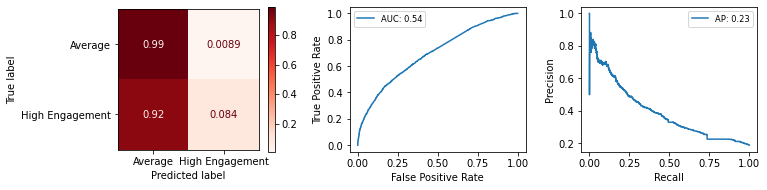

In [ ]:
xgb_clf = xgb.XGBClassifier(n_jobs=-1, max_delta_step=1)

if rerun_grid:
    xgb_clf = xgb.XGBClassifier(n_jobs=-1, max_delta_step=1)

    # Subbing Logistic Regression for the classifier
    clf_pipe = Pipeline([
        ('col_trans', cols_trans),
        ('clf', xgb_clf)
    ])

    # classifier-specific params for XGB
    clf_params = {'clf__max_depth': [3, 5],
                'clf__gamma': [0, 0.1]}

    # create grid params for XGB
    grid_params = [{**common_params, **binary_params, **clf_params},
                {**common_params, **count_params, **clf_params}]

    model_name = "XGB_binary"

    # run gridsearch for XGB
    model_eval.clf_gridsearch_wpipe(clf_pipe, grid_params, X_train, y_train, X_test, 
                y_test, class_labels, file_name=model_name, save_path=save_path, 
                scoring='recall', score_type='std')
else:
    # load and eval pipeline with best params from colab gridsearch
    best_XGB_binary_pipe, best_XGB_binary_gs = \
    model_eval.load_rebuild_eval_bestpipe('GSObject_XGB_binary.joblib.gz', 
                           X_train, y_train, X_test, y_test, 
                           class_labels, load_path=save_path)

In [ ]:
# Let's add PCA to the pipeline and try with best features from before
# PCA does not support sparse input, so I need to densify the matrices output from col_trans
cols_trans = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first'), cat_cols),
    ('txt', txt_trans_pipe, text_col)
], sparse_threshold=0)

clf_pipe = Pipeline([
    ('col_trans', cols_trans),
    ('pca', PCA(n_components=5)),
    ('clf', xgb_clf)
])

# let's try adding PCA
xgb_params = {"col_trans__txt__vect__stop_words": nltk_stopwords + punc,
    "col_trans__txt__vect__ngram_range": (1,2),
    "col_trans__txt__vect__max_features": 100000,
    'clf__max_depth': 5,
    'clf__gamma': 0.1}

clf_pipe.set_params(**xgb_params)

cross_val_score(clf_pipe, X_train, y_train, scoring='recall', verbose=1)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Turns out I don't have enough memory to try PCA with this large of a dataset.
I will instead try Truncated SVD, which I should be able to use with a sparse
matrix.

In [ ]:
# Let's try TruncatedSVD
cols_trans = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first'), cat_cols),
    ('txt', txt_trans_pipe, text_col)
])

clf_pipe = Pipeline([
    ('col_trans', cols_trans),
    ('svd', TruncatedSVD(n_components=100)),
    ('clf', xgb_clf)
])

# let's try adding PCA
xgb_params = {"col_trans__txt__vect__stop_words": nltk_stopwords + punc,
    "col_trans__txt__vect__ngram_range": (1,2),
    "col_trans__txt__vect__max_features": 100000,
    'clf__max_depth': 5,
    'clf__gamma': 0.1}

clf_pipe.set_params(**xgb_params)

cross_val_score(clf_pipe, X_train, y_train, n_jobs=-1, scoring='recall', verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.0min finished


array([0.10013908, 0.11196106, 0.11335188, 0.09666203, 0.0960334 ])

Hmm, ok, pretty terrible. I don't think XGBoost is going to help me here.

# SGD Classifier with Text Only

In [ ]:
X = df[text_col]
y = df['engage_outlier']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                               stratify=y)
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

38292
38292
9574
9574


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  4.7min finished


Pipeline(memory=None,
         steps=[('txt_trans',
                 Pipeline(memory=None,
                          steps=[('vect',
                                  CountVectorizer(analyzer='word', binary=False,
                                                  decode_error='strict',
                                                  dtype=<class 'numpy.int64'>,
                                                  encoding='utf-8',
                                                  input=<function tokenize_lemma_stem at 0x7f0502d20320>,
                                                  lowercase=True, max_df=1.0,
                                                  max_features=10000, min_df=1,
                                                  ngram_range=(1, 2),
                                                  preprocessor=None,
                                                  stop_words=['a', 'abo...
                ('clf',
                 SGDClassifier(alpha=0.1, average=False,
       

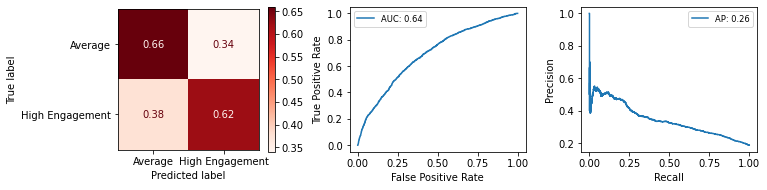

In [ ]:
# text pre-processing pipeline to transform into vectors
txt_trans_pipe = Pipeline([
    ('vect', CountVectorizer(nlp_prep.tokenize_lemma_stem)),
    ('tfidf', TfidfTransformer())
])

sgd_clf = SGDClassifier(n_jobs=-1, class_weight='balanced', loss='hinge')

# Subbing SVM for the classifier
clf_pipe = Pipeline([
    ('txt_trans', txt_trans_pipe),
    ('clf', sgd_clf)
])

grid_params = {"txt_trans__vect__stop_words": [custom_stopwords + custom_punc],
    "txt_trans__vect__ngram_range": [(1,2)],
    "txt_trans__vect__max_features": [10000, 100000],
    "clf__alpha": [1, 0.1],
    "clf__max_iter": [7],
    "clf__fit_intercept": [True, False]}

model_name = "SVM_fb_text"

# run gridsearch for SVM
model_eval.clf_gridsearch_wpipe(clf_pipe, grid_params, X_train, y_train, X_test, 
            y_test, class_labels, file_name=model_name, save_path=save_path, 
            scoring='recall', score_type='std', n_jobs=1)